In [1]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as tt
from torch.utils.data import random_split
from torchvision.utils import make_grid
from torchvision.transforms import ToTensor
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [2]:
import os
# I run it as default dir, and not change it to OOd status
DATA_DIR_TRAIN = '/Data/federated_learning/large_vlm_distillation_ood/Resnet18_classification/car_data/car_data/train/'
#DATA_DIR_TRAIN = '/Data/federated_learning/large_vlm_distillation_ood/Resnet18_classification/s_cars_ood/train/'
train_classes = os.listdir(DATA_DIR_TRAIN)

DATA_DIR_TEST = '/Data/federated_learning/large_vlm_distillation_ood/Resnet18_classification/car_data/car_data/test/'
#DATA_DIR_TEST = '/Data/federated_learning/large_vlm_distillation_ood/Resnet18_classification/s_cars_ood/test/'
test_classes = os.listdir(DATA_DIR_TEST)

train_classes[:5], test_classes[:5]

(['Acura TL Type-S 2008',
  'Audi S4 Sedan 2012',
  'Dodge Journey SUV 2012',
  'Honda Accord Coupe 2012',
  'Chevrolet Express Cargo Van 2007'],
 ['Acura TL Type-S 2008',
  'Audi S4 Sedan 2012',
  'Dodge Journey SUV 2012',
  'Honda Accord Coupe 2012',
  'Chevrolet Express Cargo Van 2007'])

In [3]:
# Tie the class indices to their names

def find_classes(dir):
    train_classes = os.listdir(dir)
    train_classes.sort()
    train_class_to_idx = {train_classes[i]: i for i in range(len(train_classes))}
    return train_classes, train_class_to_idx
    test_class_to_idx = {test_classes[i]: i for i in range(len(test_classes))}
    return test_classes, test_class_to_idx

train_classes, train_c_to_idx = find_classes(DATA_DIR_TRAIN)
test_classes, test_c_to_idx = find_classes(DATA_DIR_TEST)

In [4]:
train_classes[:5], test_classes[:5]

(['AM General Hummer SUV 2000',
  'Acura Integra Type R 2001',
  'Acura RL Sedan 2012',
  'Acura TL Sedan 2012',
  'Acura TL Type-S 2008'],
 ['AM General Hummer SUV 2000',
  'Acura Integra Type R 2001',
  'Acura RL Sedan 2012',
  'Acura TL Sedan 2012',
  'Acura TL Type-S 2008'])

In [5]:
len(train_classes), len(test_classes)

(196, 196)

In [6]:
# Tie the class indices to their names

def find_classes(dir):
    test_classes = os.listdir(dir)
    test_classes.sort()
    test_class_to_idx = {test_classes[i]: i for i in range(len(test_classes))}
    return test_classes, test_class_to_idx
test_classes, test_c_to_idx = find_classes(DATA_DIR_TEST)

In [7]:
def extract_class(Datasets):
  for vals in os.listdir(Datasets):
    print(vals)

In [8]:
#extract_class(DATA_DIR_TRAIN)

In [9]:
train_dataset = ImageFolder(DATA_DIR_TRAIN, transform = ToTensor())
test_dataset = ImageFolder(DATA_DIR_TEST, transform = ToTensor())

In [10]:
len(train_dataset), len(test_dataset)

(8144, 8041)

In [11]:
image, label = train_dataset[0]
print('image_shape:', image.shape, 'Label:',label)

image_shape: torch.Size([3, 525, 700]) Label: 0


In [12]:
image, label = train_dataset[1]
print('image_shape:', image.shape, 'Label:',label)

image_shape: torch.Size([3, 64, 85]) Label: 0


In [13]:
def show_example(img, label):
    print('Label: ', train_dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Label:  AM General Hummer SUV 2000 (0)


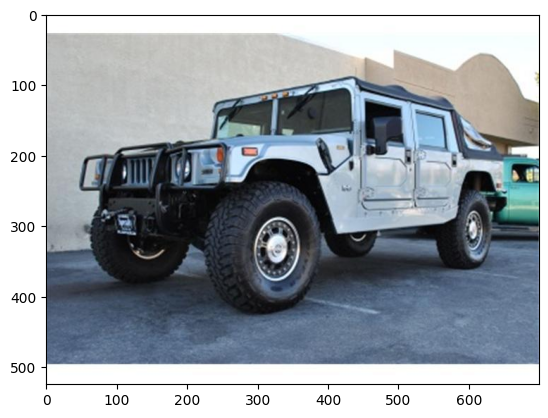

In [14]:
show_example(*train_dataset[0])

Label:  AM General Hummer SUV 2000 (0)


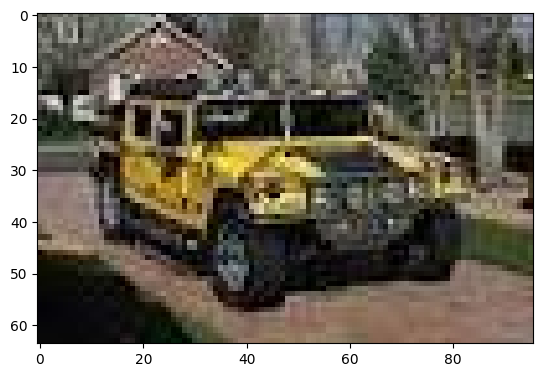

In [15]:
show_example(*test_dataset[0])

In [16]:
train_tfms = tt.Compose([tt.Resize((256, 256)),
                         tt.RandomRotation(0),
                         tt.ToTensor(),
                         tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
test_tfms = tt.Compose([tt.Resize((256, 256)),
                        tt.ToTensor(),
                        tt.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [17]:
train_dataset = ImageFolder(DATA_DIR_TRAIN, transform = train_tfms)
test_dataset = ImageFolder(DATA_DIR_TEST, transform = test_tfms)

In [18]:
# Pick the last 4 from the training dataset
train_dataset.classes[-5:-1]

['Volkswagen Golf Hatchback 2012',
 'Volvo 240 Sedan 1993',
 'Volvo C30 Hatchback 2012',
 'Volvo XC90 SUV 2007']

In [19]:
# Lift index 5: 9 in the test dataset
test_dataset.classes[5:9]

['Acura TSX Sedan 2012',
 'Acura ZDX Hatchback 2012',
 'Aston Martin V8 Vantage Convertible 2012',
 'Aston Martin V8 Vantage Coupe 2012']

In [20]:
len(train_dataset), len(test_dataset)

(8144, 8041)

In [21]:
image, label = train_dataset[0]
print('image_shape:', image.shape, 'Label:',label)

image_shape: torch.Size([3, 256, 256]) Label: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  AM General Hummer SUV 2000 (0)


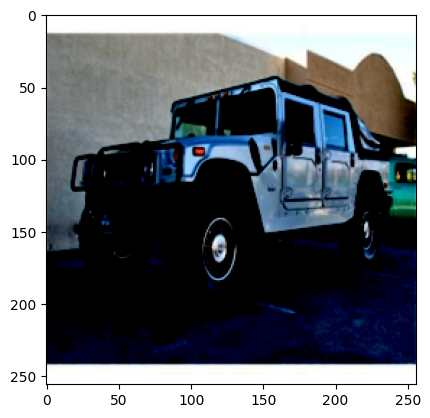

In [22]:
show_example(*train_dataset[0])

## Training and Validation Datasets

While building real world machine learning models, it is quite common to split the dataset into 3 parts:

1. **Training set** - used to train the model i.e. compute the loss and adjust the weights of the model using gradient descent.
2. **Validation set** - used to evaluate the model while training, adjust hyperparameters (learning rate etc.) and pick the best version of the model.
3. **Test set** - used to compare different models, or different types of modeling approaches, and report the final accuracy of the model.

Since there's no predefined validation set, we can set aside a small portion (10 percent of images) of the training set to be used as the validation set. We'll use the `random_split` helper method from PyTorch to do this. To ensure that we always create the same validation set, we'll also set a seed for the random number generator.

In [23]:
random_seed = 42
torch.manual_seed(random_seed);

In [24]:
val_percent = 0.1
val_size = int(val_percent * len(train_dataset))
train_size = len(train_dataset) - val_size

train_ds, val_ds = random_split(train_dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(7330, 814)

In [25]:
batch_size = 32

In [26]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size * 2, num_workers = 4, pin_memory=True)

In [27]:
def show_batch(dl):
  for images, labels in dl:
    fig, ax = plt.subplots(figsize = (12,6))
    ax.set_xticks([]), ax.set_yticks([])
    ax.imshow(make_grid(images, nrow=16).permute(1,2,0))
    break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


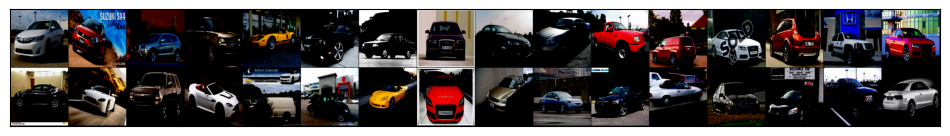

In [28]:
show_batch(train_dl);

In [29]:
simple_model = nn.Sequential(
    nn.Conv2d(3,8, kernel_size = 3, stride = 1, padding = 1),
    nn.MaxPool2d(2,2)
)

In [30]:
for images, labels in train_dl:
  print('images.shape:', images.shape)
  out = simple_model(images)
  print('out.shape:', out.shape)
  break

images.shape: torch.Size([32, 3, 256, 256])
out.shape: torch.Size([32, 8, 128, 128])


In [31]:
class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.2f} %".format(
            epoch, result['train_loss'], result['val_loss'], 100*(result['val_acc'])))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [32]:
class StanfordCarsModel(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            nn.Conv2d(3, 8, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(8, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 16 x 128 x 128

            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 32 x 64 x 64

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # output: 64 x 32 x 32

            nn.Flatten(), 
            nn.Linear(64*32*32, 1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512, 196))
        
    def forward(self, xb):
        return self.network(xb)

In [33]:
import torchvision.models as models
class StanfordCarsResNet18(nn.Module):
    def __init__(self, num_classes=196):
        super(StanfordCarsResNet18, self).__init__()
        resnet = models.resnet18(pretrained=True)
        
        self.network = nn.Sequential(
            # First convolutional layer
            resnet.conv1,  # Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            resnet.bn1,    # BatchNorm2d(64)
            nn.ReLU(inplace=True),
            resnet.maxpool,  # MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
            
            # Residual layers
            resnet.layer1,  # Layer1
            resnet.layer2,  # Layer2
            resnet.layer3,  # Layer3
            resnet.layer4,  # Layer4
            
            # Adaptive average pooling and fully connected layers
            nn.AdaptiveAvgPool2d((1, 1)),  # Adapted to ensure compatibility with different input sizes
            nn.Flatten(start_dim=1),
            nn.Linear(resnet.fc.in_features, num_classes)  # Linear(512, num_classes)
        )
    
    def forward(self, x):
        return self.network(x)

# Example usage:
num_classes = 196  # Adjust to the number of classes in the Stanford Cars dataset
model = StanfordCarsResNet18(num_classes)
model

/home/ariel/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ariel/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


StanfordCarsResNet18(
  (network): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runnin

In [34]:
# model = StanfordCarsModel()
# model

In [35]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [36]:
device = get_default_device()
device

device(type='cuda')

In [37]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
to_device(model, device);

## Training the Model

We'll define two functions: `fit` and `evaluate` to train the model using gradient descent and evaluate its performance on the validation set. For a detailed walkthrough of these functions, check out the [previous tutorial](https://jovian.ai/aakashns/03-logistic-regression).

In [38]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [39]:
model = to_device(StanfordCarsModel(), device)

In [40]:
evaluate(model, val_dl)

{'val_loss': 5.278131484985352, 'val_acc': 0.006009615492075682}

In [41]:
num_epochs = 25
opt_func = torch.optim.Adam
lr = 5e-2

In [42]:
history = fit(num_epochs, lr, model, train_dl, val_dl, opt_func)

Epoch [0], train_loss: 49394.3398, val_loss: 5.3065, val_acc: 0.53 %
Epoch [1], train_loss: 5.3137, val_loss: 5.3093, val_acc: 0.12 %
Epoch [2], train_loss: 5.3134, val_loss: 5.3038, val_acc: 0.29 %
Epoch [3], train_loss: 5.3111, val_loss: 5.3121, val_acc: 0.24 %
Epoch [4], train_loss: 5.3134, val_loss: 5.3054, val_acc: 0.72 %
Epoch [5], train_loss: 5.3128, val_loss: 5.3003, val_acc: 0.48 %
Epoch [6], train_loss: 5.3134, val_loss: 5.3185, val_acc: 0.36 %
Epoch [7], train_loss: 5.3126, val_loss: 5.2985, val_acc: 1.78 %
Epoch [8], train_loss: 5.3127, val_loss: 5.3084, val_acc: 0.60 %
Epoch [9], train_loss: 5.3082, val_loss: 5.3282, val_acc: 0.12 %
Epoch [10], train_loss: 5.3119, val_loss: 5.3124, val_acc: 0.24 %
Epoch [11], train_loss: 5.3111, val_loss: 5.3042, val_acc: 0.24 %
Epoch [12], train_loss: 5.3130, val_loss: 5.3256, val_acc: 0.53 %
Epoch [13], train_loss: 5.3129, val_loss: 5.3124, val_acc: 0.12 %
Epoch [14], train_loss: 5.3097, val_loss: 5.3127, val_acc: 0.65 %
Epoch [15], trai

In [62]:
acc = []
for item in history[15:]:
    accuracy = item['val_acc']
    acc.append(accuracy)
import numpy as np
val_acc = np.mean(acc)
print(100*val_acc)

0.4253762657754123
